# Algorithm Hierarchical Clustering M

describe

In [3]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class Cluster:
    
    def __init__(self, n):
        ''' '''
        self.n = n # номер класетра (начальной точки)
        self.nodes = set([n]) # объединенные с кластером точки 
        self.join_n  = -1 # номер кластера с которым слит
        self.dist = -1 # расстояние при слиянии (dist <= 0)

    def active(self):
        ''' '''
        return self.join_n == -1
        
    def merge(self, c, dist):
        ''' '''
        self.nodes = self.nodes.union(c.nodes) 
        c.join_n = self.n
        c.dist = np.abs(dist)
        
    def get_n(self):
        ''' '''
        if self.join_n == -1:
            return self.n
        return self.join_n
        
class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
            
    
    def fit(self, x):
        ''' '''
        self._c_all = []
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size): 
            C.append( Cluster(i) )
        
        delta = self.delta
        
        for i in range(self.max_iteration): 
            d = np.min(M[M > 0])  
            #d = self._get_min(M, C) * self.alpha
            if d > delta:
                delta = d  
            delta = delta * self.alpha    
            if(self.debug):   
                print('delta: %.3f, d: %.3f' % (delta, d))    
            M_ = M - delta
            ''' join clusters '''
            join = False
        
            for i in range(size):  
                for j in range(i+1,size):  
                    
                    if(M[i][j] <= 0 or M_[i][j] > 0):
                        continue 
                        
                    if C[i].dist > np.abs(M_[i][j]): 
                        continue
                        
                    a = C[i].get_n()
                    b = C[j].get_n() 
                    if(a == b):
                        continue 
            
                    C[a].merge(C[b], M_[i][j]) 
                    for s in C[b].nodes:
                        #C[s].join_n = a
                        C[a].merge(C[s], M_[i][j])
                    join = True        
            if join == False: 
                delta = delta * self.betta 
                continue
            
            M =   M_ 
                    
            if len(M[M > 0]) == 0:
                break
               
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c.active() == True): 
                    for i in c.nodes:
                        y_[i] = cl
                    cl = cl + 1
                    
            self._c_all.append(y_)  
          
            if len(np.unique(y_)) <= self.n_clusters: 
                break
            neg,pos = [],[]    
            ''' 
            
            
            for i in range(size): 
                for j in range(i,size):
                    if C[i].active() == False:
                        continue
                    if C[j].active() == False:
                        continue
                        
                    if(M[i][j] <= 0):
                        neg.append(np.abs(M[i][j]) + delta)
                    elif(M[i][j] > 0):
                        pos.append(M[i][j])    
            if(self.debug):
                print('Sum pos: %.3f, sum neg: %.3f, Std pos: %.3f, Std neg: %.3f' % 
                      (sum(pos) , sum(neg) ,np.std(pos), np.std(neg))) 
            if np.std(pos) == 0:
                break
            if self.stop_neg_sum and sum(pos) / len(pos) < sum(neg) / len(neg): 
                print('sum(pos) < sum(neg)')
                break 
            '''
            print(np.mean(M[M > 0]), len( np.unique(y_)))
            print(np.std(M[M > 0]), np.std(np.abs(M[M < 0])), np.mean(np.abs(M[M < 0])))
            
        self.labels_ = y_         
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [201]:
v = np.array([[1,1,1,0,0],[0,1,1,1,0]])
print(v)
w = np.where(v == 0)
print(w)

[[1 1 1 0 0]
 [0 1 1 1 0]]
(array([0, 0, 1, 1]), array([3, 4, 0, 4]))


In [212]:
v = np.array([[1,1,1,0,0],[0,1,1,1,0]])
print(v)
v[:,2] =10
print(v)

[[1 1 1 0 0]
 [0 1 1 1 0]]
[[ 1  1 10  0  0]
 [ 0  1 10  1  0]]


In [265]:
class HC:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
    
    def log(self, msg):
        if(self.debug):
            print(msg)
    
    def fit(self, x): 
        ''' '''
        A = euclidean_distances(x,x)
        #print(A)
        self._c_all = []
        C = A.copy()
        labels = [n +1 for n in range(0,len(x))]
        print(labels)
        n = 1 
        mim_1 = 0
        for i in range(self.max_iteration):
            if len(A[A>0]) == 0:
                break
            mim_ = min(A[A>0]) * self.alpha
            if mim_ > mim_1:
                mim_1 = mim_
            mim_1   = mim_   
            
            #A = A - mim_1  
            A[(A - mim_1 <= 0) & (C > 0)] = -n
            w1,w2 = np.where(A == -n) 
            #print(A)
            lab= len(np.unique(labels))
            for j in range(0, len(w1)):
                #print((w1[j],w2[j]))
                labels[w1[j]] = labels[w2[j]]
                #A[w2[j],:]=0
                #A[:,w1[j]]=0
            #print(labels)
            if len(np.unique(labels)) == lab:
                continue
            self._c_all.append(labels.copy())
            if(len(np.unique(labels)) <= self.n_clusters):
                break
            self.log('min: %.10f, len: %d' % (mim_1, len(np.unique(labels))))     
            
            n = n + 1
        print(labels)
        #print(C)
        return labels


In [266]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([
    [1,1],
    [1,2],
    [2,2],
    [2,1],
    
    #[4,4],
    
    [5,5], 
    [6,6],
    [6,7],
    
    [3.5,7],
    
    # 
    [3.6,7.1],
    [3.7,6.9],
    [3.8,6.9] 
]) 

x = np.array([
    [1,1],
    [1.1,1],
    [2.1,2],
    [1.5,2],
    
    [10,10],
    [12,14],
    [11,12],
    [11,11],
])

def draw(x, y):
    k = 2
    U,s,vh = np.linalg.svd(x) 
    k = min(k, len(s))

    x1 = np.dot(U[:,0:k] * s[0:k], vh[0:k]) 

    plt.rcParams["figure.figsize"] = (12,12)
    plt.scatter(x1[:,0], x1[:,1], c=y)

   

In [267]:
hc1 = HC(alpha = 2.0, debug=True)
Y_ = hc1.fit(x)


[1, 2, 3, 4, 5, 6, 7, 8]
min: 0.2000000000, len: 7
min: 1.2000000000, len: 4
min: 2.8284271247, len: 2
[8, 8, 8, 8, 8, 8, 8, 8]


[2, 2, 3, 4, 5, 6, 7, 8]


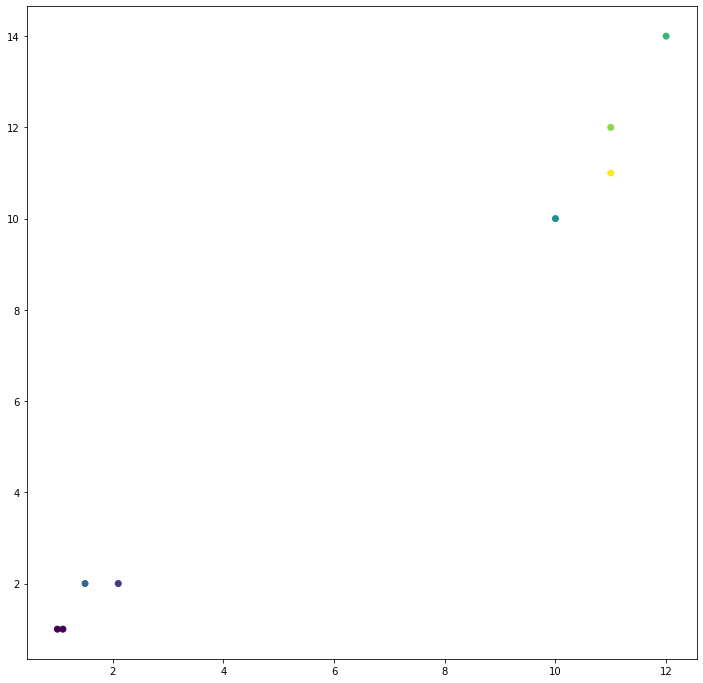

In [272]:
n =-4
print(hc1._c_all[n])
draw(x, hc1._c_all[n])

Hierarchical clustering
delta: 0.100, d: 0.100
3.7931358893328553 10
2.3524558450147612 0.0 0.09999999999999006
delta: 0.100, d: 0.041
3.763922955995045 9
2.3168687568939927 0.054441116610729444 0.16781048583500535
delta: 0.100, d: 0.024
3.8871572071952647 8
2.193060537749245 0.10695671228720563 0.2074783176940731
delta: 0.100, d: 0.016
delta: 0.200, d: 0.016
delta: 0.400, d: 0.016
delta: 0.800, d: 0.016
3.53730983167613 4
1.9410969901169095 0.4202398214368708 0.7189269436223902
delta: 0.800, d: 0.314
2.973146144064228 3
1.7966113971174535 0.5370110148858708 1.359982250392219
delta: 0.800, d: 0.302
3.3144167479016238 2
0.7798844491283686 1.0127650460727267 1.4099794128386332
delta: 1.543, d: 1.543
delta: 3.085, d: 1.543
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


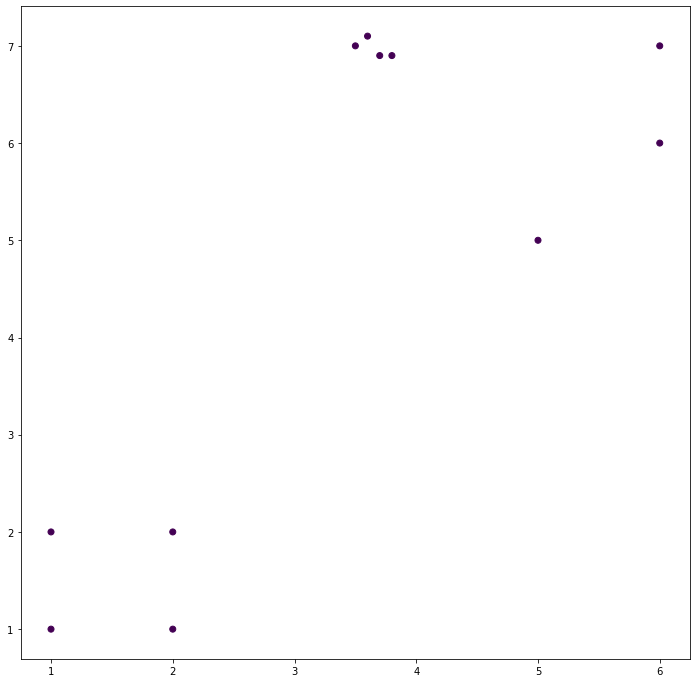

In [115]:
#x = np.array([
#    [1,1],[2.2,2.2],[3.5,3.5],[4.9,4.9]
#])
hc = HierarchicalClustering(alpha = 1.0, debug=True)
hc.print_name()
Y_ = hc.fit(x)
print(Y_)
draw(x, Y_)

[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


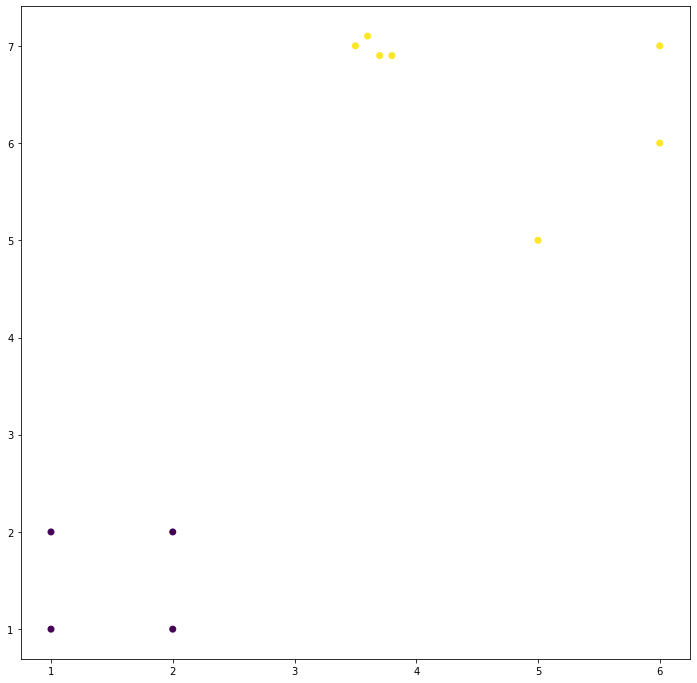

In [116]:
n = -2
print(hc._c_all[n])
draw(x, hc._c_all[n])

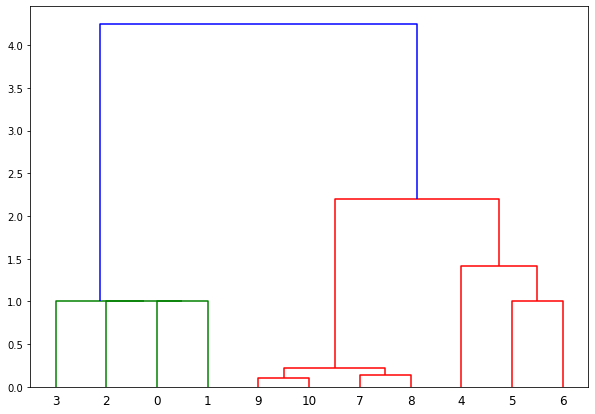

In [117]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(x, 'single')

labelList = range(1, len(x))

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
           # labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Text(0.5, 1.0, 'Дерево')

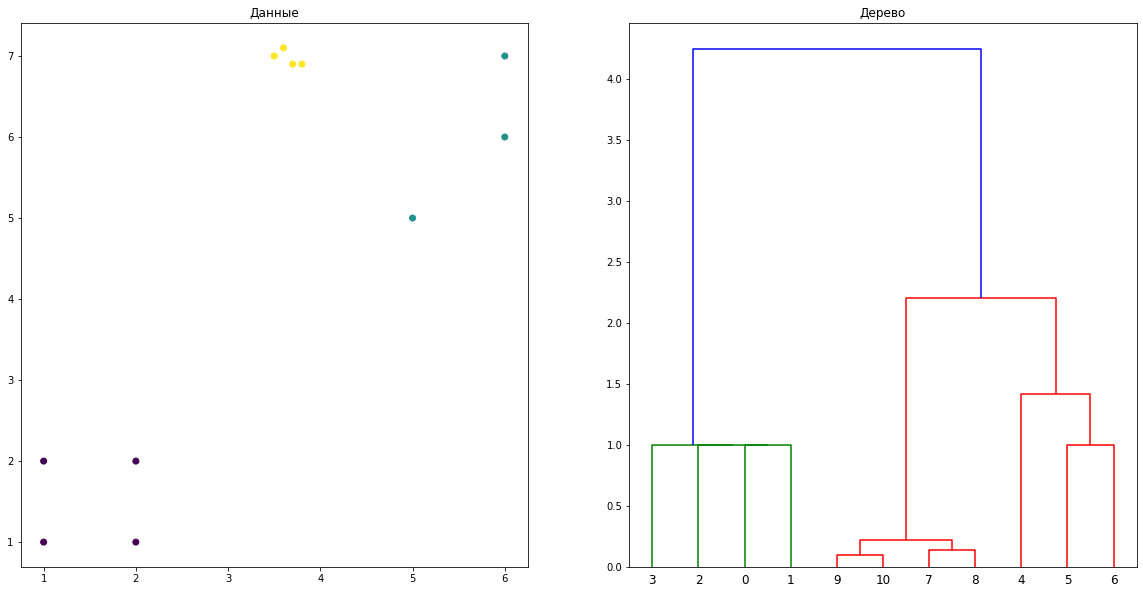

In [118]:
plt.rcParams["figure.figsize"] = (20,10)
np.random.seed(0)

# data
plt.subplot(1, 2, 1)
draw(x, hc._c_all[-3])
plt.title(u'Данные')


# view
plt.subplot(1, 2, 2)
dendrogram(linked,
            orientation='top',
           # labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.title(u'Дерево')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
min: 0.2000000000, len: 119
min: 0.4000000000, len: 50
min: 0.8000000000, len: 18
min: 1.6124515497, len: 5
[150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150

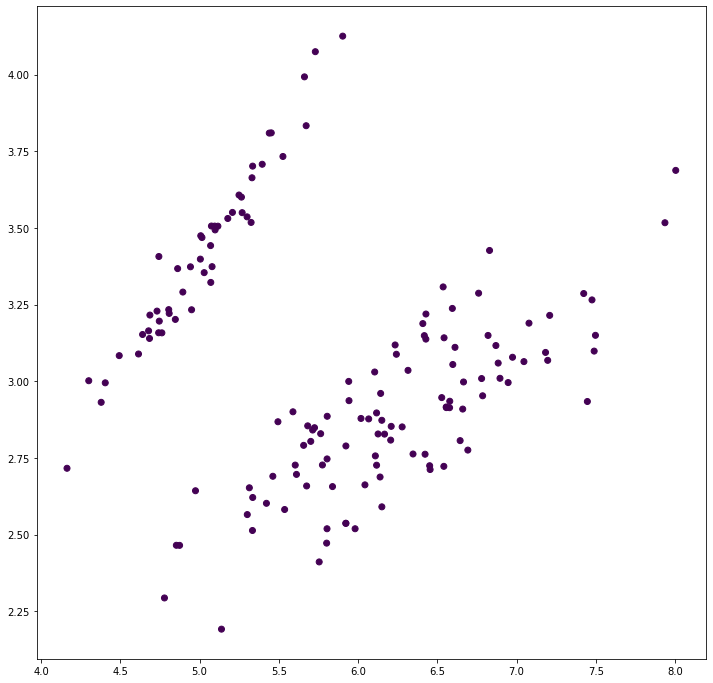

In [273]:
data = load_iris()
ix = data.data
iy = data.target
#cl = HierarchicalClustering(alpha=1.3, debug=1, max_iteration=100)
#iiy = cl.fit(ix)

cl = HC(alpha = 2.0, debug=True)
iiy = cl.fit(ix)

draw(ix,iiy)

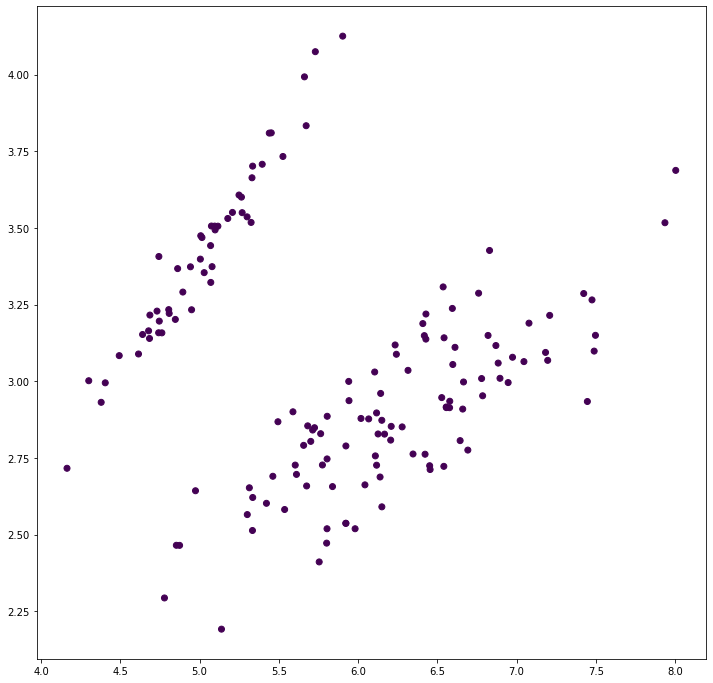

In [275]:
draw(ix,cl._c_all[-1])
#draw(ix, iy)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

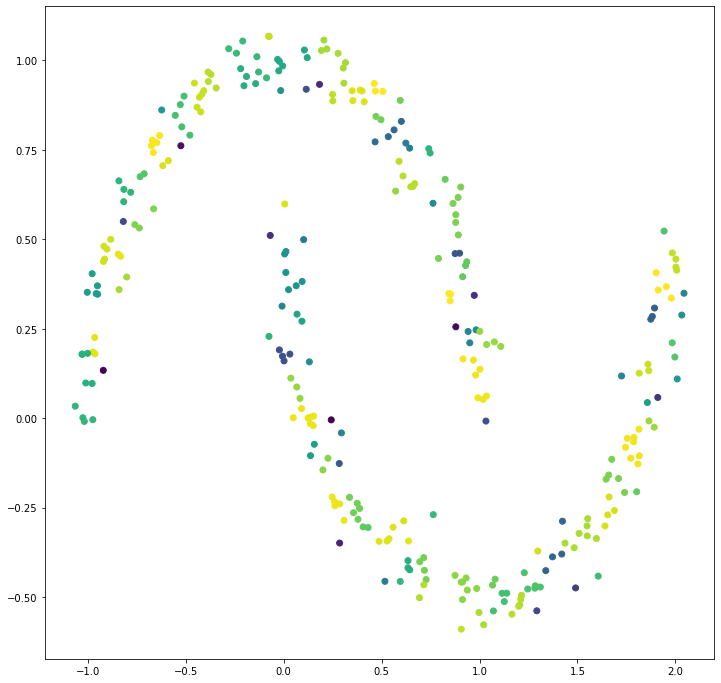

In [276]:
# noisy_moons
from sklearn import cluster, datasets, mixture
mx,my =  datasets.make_moons(n_samples=300, noise=.05)

#cl2 = HierarchicalClustering(alpha=1., debug=1)
#mmy = cl2.fit(mx)
cl2 = HC(alpha = 1.0, debug=False, max_iteration=300)
mmy = cl2.fit(mx)
draw(mx,mmy)

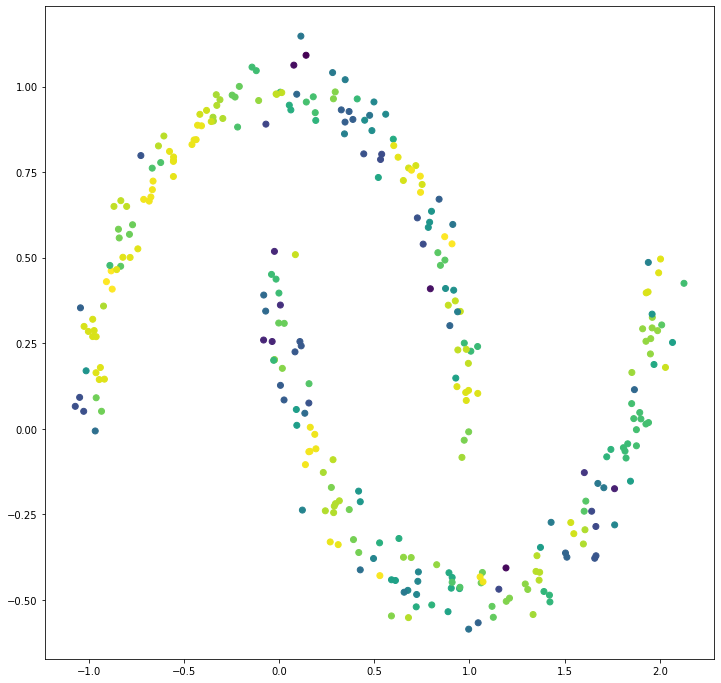

In [256]:
n = -10
#print(cl2._c_all[n])
draw(mx,cl2._c_all[n])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

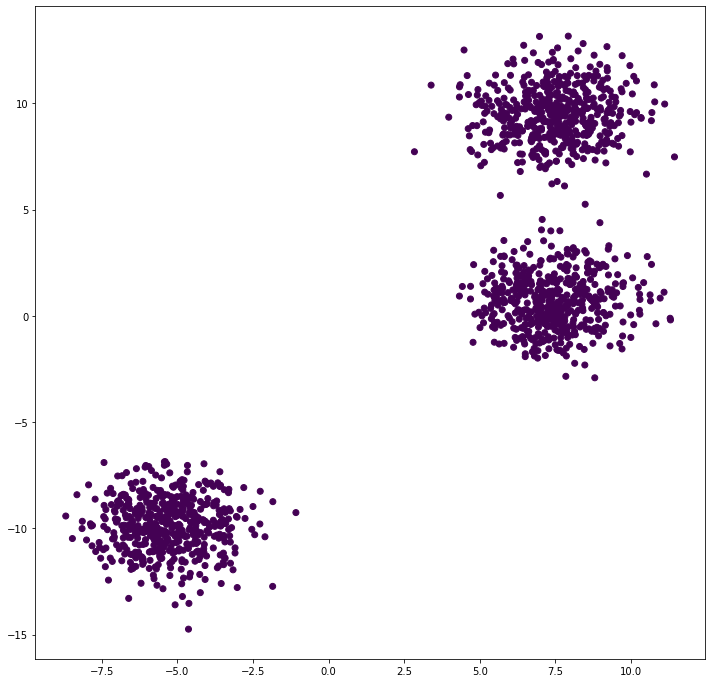

In [285]:
bx,_ =  datasets.make_blobs(n_samples=1530, random_state=8, cluster_std=1.3) 

cl3 = HC(alpha=2.)#HierarchicalClustering(alpha=1., debug=1,max_iteration=100,delta=.5)
by = cl3.fit(bx)
draw(bx,by)

[1527 1529 1530]


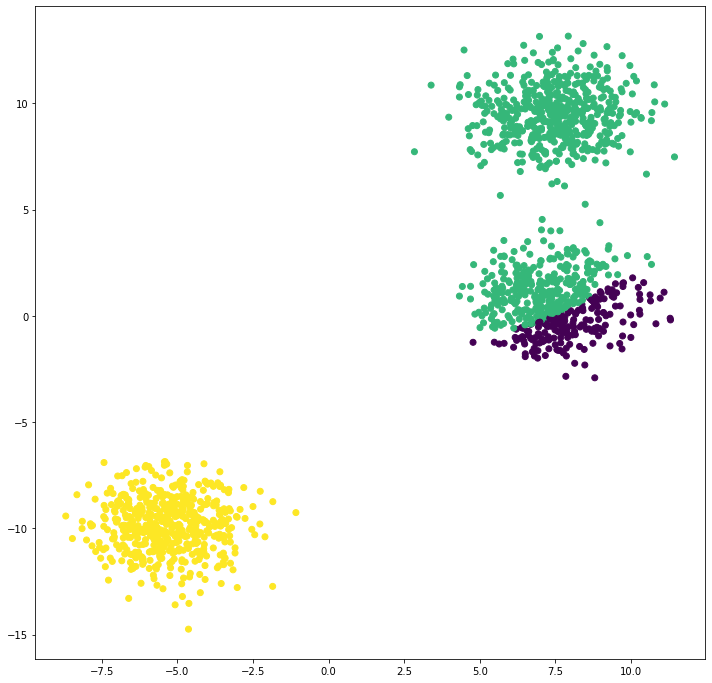

In [289]:
n = -3
#print(cl3._c_all[n])
print(np.unique(cl3._c_all[n]))
draw(bx,cl3._c_all[n])

delta: 0.050, d: 0.002
0.9660226926567637 155
0.47361720328109025 0.01856778625564287 0.03149791714216602
delta: 0.050, d: 0.000
0.9267507621296289 31
0.4655125675475263 0.033550650208402664 0.04631206017570008
delta: 0.050, d: 0.000
0.8883450051153015 7
0.4570686816354504 0.04479406306291343 0.06770068614137953
delta: 0.050, d: 0.000
0.8506165463954959 3
0.4484842870126716 0.0573200149903911 0.08970276074833969
delta: 0.050, d: 0.000
delta: 0.100, d: 0.000
0.7728789585483156 2
0.43402540810179696 0.08297430412324182 0.13898092252275998
delta: 0.100, d: 0.000


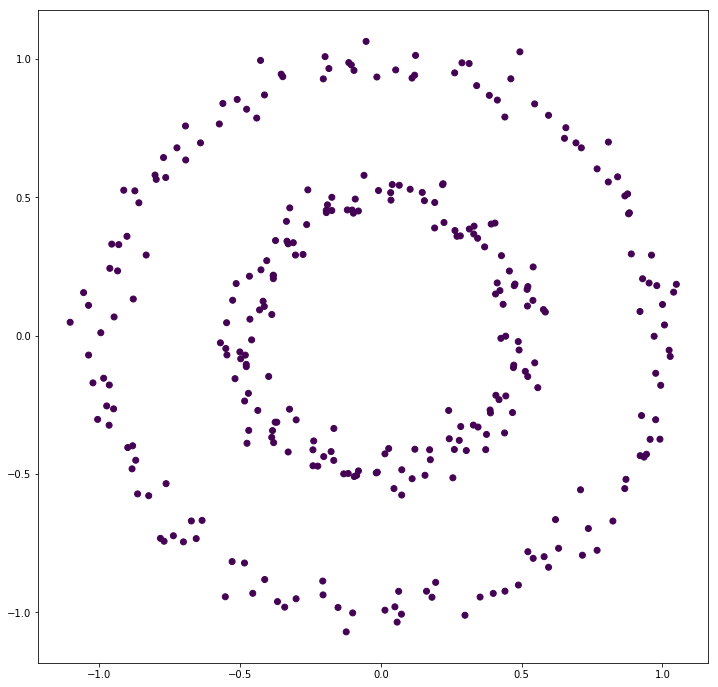

In [83]:
bx,by = datasets.make_circles(n_samples=300, factor=.5, noise=.05) 
cl31 = HierarchicalClustering(alpha=1., debug=1,max_iteration=100,delta=.05)
by = cl31.fit(bx)
draw(bx,by)

[0. 1. 2. 3. 4. 5. 6.]


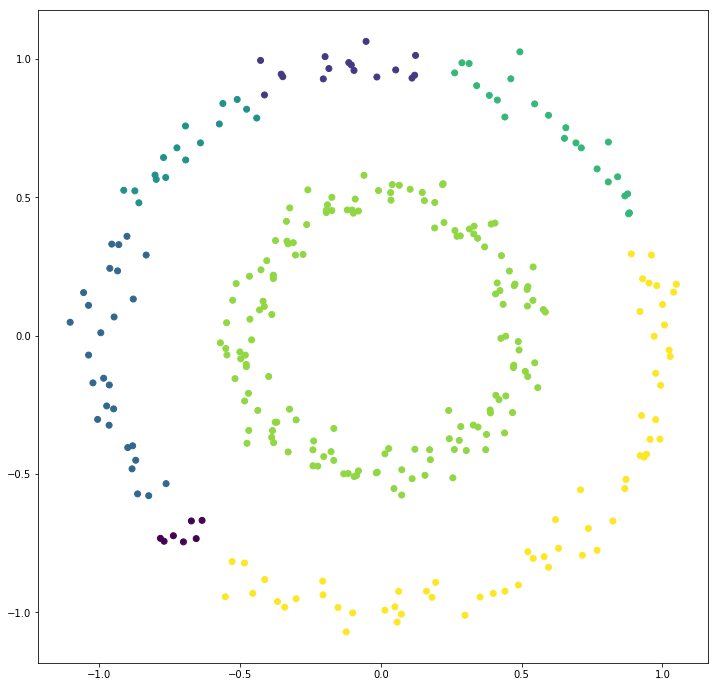

In [86]:
n = -4
#print(cl3._c_all[n])
print(np.unique(cl31._c_all[n]))
draw(bx,cl31._c_all[n])

### fetch_20newsgroups

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
data_test = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42)
print('data loaded')

data loaded


In [4]:
y_train, y_test = data_train.target, data_test.target

In [7]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [10]:
%%time
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

CPU times: user 6.38 s, sys: 16 ms, total: 6.4 s
Wall time: 6.41 s


In [13]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=100): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(x) 
    return x1 

In [14]:
%%time
X_train_ = encode_svd(X_train)

CPU times: user 3min 6s, sys: 1min 36s, total: 4min 43s
Wall time: 2min 55s


In [15]:
print(X_train_.shape)

(11314, 100)


In [46]:
# TODO sklearn.metrics. cos test!!!

In [48]:
###

In [6]:
 
A1 = np.array([
    [0.982772, 0.376789,0.176096,0.185309,0.180585,0.066007,0.171831,0.012917], 
    [0.982772, 0.376789, 0.176096, 0.185309 ,0.180585 ,0.066007 ,0.171831 ,0.012917],
    [0.982772, 0.376789,0.176096,0.185309,0.180585,0.066007,0.171831,0.012917],
    [0.982772, 0.376789,0.176096,0.185309,0.180585,0.066007,0.171831,0.012917],  
    [0.982772,0.376789 ,0.176096 ,0.185309,0.180585,0.066007,0.171831,0.012917]
])
A2 = np.array([
    [0.984338,0.467409,0.169374,0.189054,0.178674,0.052887,0.169602,0.345301],
    [0.986688, 0.476948,0.115043,0.166771,0.136160,0.001436,0.125191,0.153431],
    [0.990603,0.429253,0.177958,0.220205,0.196840,0.061198,0.187378,0.061084],
    [0.989037,0.310016,0.177226,0.199068,0.187513,0.044096,0.178510,0.019783],
    [0.989037,0.276630,0.144016,0.159553,0.151387,0.037046,0.142037,0.011656]
])
A3 = np.array([
    [0.981989,0.419714,0.169247,0.187106,0.177729,0.058492,0.168691,0.310419],
    [0.991386,0.410175,0.125168,0.162897,0.141562,0.013601,0.131270,0.130096],
    [0.991386,0.422893,0.109823,0.157332,0.129353,-0.007105,0.118373,0.097300],
    [0.991386,0.337043,0.146196,0.174445,0.159076,0.017017,0.149379,0.019637],
    [0.989820,0.275040,0.128028,0.146114,0.136475,0.030079,0.126803,0.012542]
])

A4 = np.array([
    [0.983555,0.376789,0.167232,0.185275,0.175792,0.058084,0.166720,0.488023],
    [0.982772,0.435612,0.065085,0.201967,0.098445,0.009293,0.083275,0.172452],
    [0.986688,0.432432,0.034193,0.204036,0.058570,0.004121,0.041016,0.608160],
    [0.985121,0.352941,0.013261,0.160739,0.024501,-0.003402,0.010527,0.875388],
    [0.983555,0.308426,0.006901,0.184096,0.013303,-0.001016,0.000226,0.969398]
])

A5 = np.array([
    [0.934221,0.143084,0.013787,0.017132,0.015279,0.000419,0.004568,0.730702],
    [0.939702,0.163752,0.014702,0.017661,0.016046,0.000697,0.005549,0.716658],
    [0.938136,0.135135,0.016108,0.020480,0.018033,0.000273,0.007072,0.737421],
    [0.948316,0.151033,0.014269,0.016401,0.015261,0.000103,0.005376,0.703300],
    [0.957713,0.144674,0.014664,0.016800,0.015660,0.000518,0.005393,0.697546]
])

A6 = np.array([
    [0.949883, 0.108108,0.017042,0.018846,0.017899,-0.001035,0.007740,0.688593],
    [0.876273,0.171701,0.017993,0.019235,0.018594,-0.000362,0.008794,0.698397],
    [0.212216,0.211447,0.008828,0.141528,0.016620,-0.002720,0.002747,0.991679],
    [0.975724,0.170111,0.018358,0.019102,0.018723,0.000780,0.008509,0.686397],
    [0.96711, 0.162162,0.015358,0.016534,0.015924,0.000189,0.005224,0.690189]
])




    


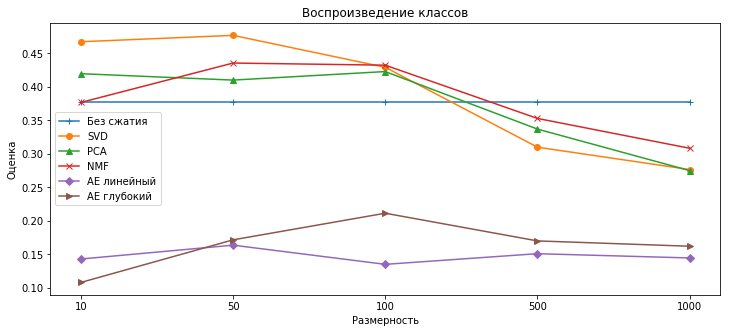

In [44]:
def draw_plot_score(n=1): 
    titles = ['', 'Воспроизведение классов','Однородность','Полнота','V- мера', 'ARI', 'AMI','Силуэт']
    title = titles[n]
    plt.rcParams["figure.figsize"] = (12,5)
    x = ['10','50','100','500','1000']
    plt.plot(x,A1[:,n], label='Без сжатия', marker='+', linestyle='-')
    plt.plot(x,A2[:,n], label='SVD', marker='o', linestyle='-')
    plt.plot(x,A3[:,n], label='PCA', marker='^', linestyle='-')
    plt.plot(x,A4[:,n], label='NMF', marker='x', linestyle='-')
    plt.plot(x,A5[:,n], label='AE линейный', marker='D', linestyle='-')
    plt.plot(x,A6[:,n], label='AE глубокий', marker='>')
    plt.xlabel('Размерность')
    plt.ylabel('Оценка')
    plt.legend()
    plt.title(title)
    
draw_plot_score(1)    

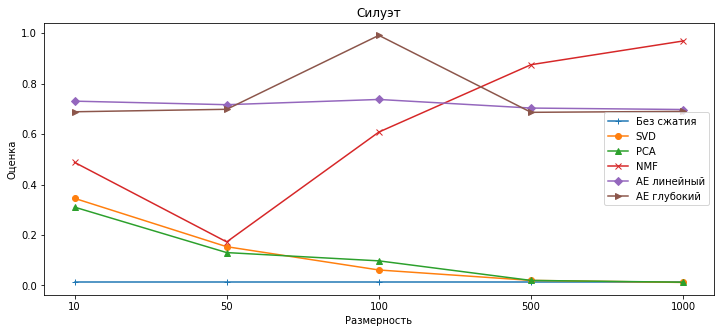

In [50]:
draw_plot_score(7) 

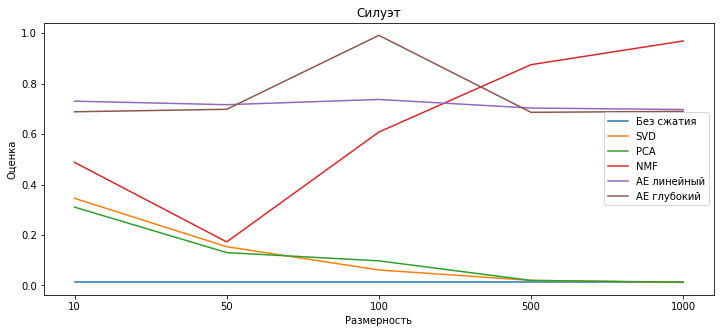

In [18]:
draw_plot_score(7, 'Силуэт')  

In [41]:
?plt.plot